In [1]:
import pandas as pd
import datetime
from pandas_profiling import ProfileReport
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import variable_transformers as vt
from feature_engine.outlier_removers import Winsorizer
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
#Read both dataframes
#Combine the details dataframe with saleshistory dataframe
details = pd.read_csv('Data/house_data_details_cleaned.csv')
history = pd.read_csv('Data/house_data_saleshistory_cleaned.csv')

In [3]:
print(details.shape, history.shape)
raw_data = pd.merge(details, history, on='parcel_number', how='left')
print(raw_data.shape)

#There are some properties in the saleshistory dataframe that are not 
#in the details dataframe. That is why the total number of observations
#do not add up after the merge

(15897, 26) (26400, 3)
(32438, 28)


In [4]:
#We'll be keeping the values from the right dataframe(for columns date and sale_price) since they exist in both dataframes
#There are a lot of null values for properties that are not in the saleshistory.We'll fill those missing values 
#with the values from the left dataframe and then drop the duplicate features from the left dataframe

print(f'Number of missing values for price after the merge and before the imputation: {raw_data.price.isnull().sum()}')
missing = raw_data.loc[raw_data['price'].isnull()].index
raw_data['date_y'] = raw_data['date_y'].fillna(raw_data['date_x'])
raw_data['price'] = raw_data['price'].fillna(raw_data['sale_price'])

raw_data.drop(['date_x', 'sale_price'], axis=1, inplace=True)
raw_data.rename(columns={'date_y': 'date', 'price':'sale_price'}, inplace=True)

print(f'Number of missing values for price after imputing the missing values: {raw_data.sale_price.isnull().sum()}')
raw_data.head()

Number of missing values for price after the merge and before the imputation: 7163
Number of missing values for price after imputing the missing values: 472


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,date,sale_price
0,33.97462,-118.13368,6224 Nye St,Condominium,1357.00000,2221560.00000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000,2020-09-28,469000.00000
1,34.15656,-118.39689,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan,2020-09-28,1910000.00000
2,34.67778,-118.45117,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000,2020-09-28,325000.00000
3,34.07296,-118.06690,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000,2020-09-28,738000.00000
4,33.77772,-118.15491,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000,2020-09-28,1185000.00000


In [5]:
df = raw_data.copy()
df.describe()

,latitude,longitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,sale_price
count,32438.00000,32438.00000,31007.00000,32251.00000,31328.00000,32438.00000,32429.00000,32438.00000,32438.00000,30411.00000,32438.00000,32438.00000,32438.00000,30246.00000,30246.00000,31966.00000
mean,34.12582,-118.27383,39480.24752,3641806.38473,1964.78773,4957060442.13956,1112350631.82247,1.99787,456463.49704,868891.28934,7.60189,6.88754,1.20291,3.39394,2.69226,2553309.61662
std,0.23241,0.21680,703387.58842,20481266.81710,25.95825,2106211705.68709,720957.74869,1.09919,267866.57341,556785.55418,13.54197,6.55729,0.43721,4.94307,4.60090,12262022.54720
min,33.70724,-118.89009,3.00000,120.00000,1883.00000,6637311.00000,1110722482.00000,1.00000,0.00000,104000.00000,0.00000,1.00000,0.00000,1.00000,1.00000,500.00000
25%,33.97783,-118.43218,1185.00000,6004.50000,1948.00000,2866051505.50000,1111985629.00000,1.00000,213100.00000,499400.00000,1.00000,3.00000,1.00000,2.00000,2.00000,365000.00000
50%,34.09745,-118.28963,1564.00000,7763.00000,1963.00000,5052003006.00000,1112356597.00000,2.00000,430902.00000,692600.00000,3.00000,5.00000,1.00000,3.00000,2.00000,705000.00000
75%,34.20372,-118.13253,2233.00000,20473.00000,1986.00000,7062030024.00000,1113024944.00000,3.00000,620501.00000,1026000.00000,9.00000,9.00000,1.00000,4.00000,3.00000,2000000.00000
max,34.81875,-117.61020,34717320.00000,1248647400.00000,2020.00000,8765024023.00000,1113469419.00000,8.00000,980031.00000,2999000.00000,136.00000,125.00000,4.00000,282.00000,184.00000,1660000000.00000


In [6]:
#Alternatively
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

In [7]:
#Before removing the observations with missing values, 
#let's remove the features we won't need so we can limit the number of observations we will need
dropped_features = ['realtyID', 'county', 'subdivision', 'census', 'tract', 'lot', 'estimated_value']

#Remove missing values for the target feature
num_obs_1 = df.shape[0]
print(f'{num_obs_1} number of observations before trim')

df.drop(dropped_features, axis=1, inplace=True)
df.dropna(inplace=True)
num_obs_2 = num_obs_1 - df.shape[0]
num_obs_3 = num_obs_1 - raw_data.dropna().shape[0]
print(f'{num_obs_3} number of missing observations when including the bad features')
print(f'{num_obs_2} number of missing observations when not including the bad features')
print(f'{df.shape[0]} current number of observations')

32438 number of observations before trim
10021 number of missing observations when including the bad features
7066 number of missing observations when not including the bad features
25372 current number of observations


In [8]:
#Convert date into a datetime object
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0       2069-09-19
1       2069-07-01
2       2069-04-23
3       2069-01-22
4       2068-06-05
           ...    
25367   1965-05-10
25368   1965-01-15
25369   1964-08-07
25370   1964-07-29
25371   1964-06-10
Name: date, Length: 25372, dtype: datetime64[ns]

In [9]:
#Correct the dates
df['sold_date'] = df['date'].apply(lambda x: x.replace(year= x.year-100) if x.year>2020 else x)
df['date'] = df['sold_date'].values.astype('datetime64[M]') #Converting the date column into the first of the month
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df.drop_duplicates(inplace=True)
df['sold_date']

0       2020-12-01
1       2020-11-13
2       2020-11-16
3       2020-11-16
4       2020-11-16
           ...    
25367   1964-12-18
25368   1964-08-07
25369   1964-07-02
25370   1964-07-29
25371   1964-06-10
Name: sold_date, Length: 25372, dtype: datetime64[ns]

In [10]:
#We will use the cpi for every corresponding sale date to help adjust the sale price based on inflation

#Add a new column that will be used for the merge
df['year'] = df['date'].dt.year

#Read in a file with consumer price index
cpi_df = pd.read_csv('Data/CPIAUCNS.csv')
cpi_df.rename(columns={'DATE':'date', 'CPIAUCNS':'cpi'}, inplace=True)
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

cpi_df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)

merged_df = pd.merge(df, cpi_df, on='date', how='left')
merged_df.drop_duplicates(inplace=True)

cpi_2020 = int(merged_df.loc[0, ['cpi']])
merged_df['sale_price_cpi'] = (merged_df['sale_price']*cpi_2020)/ merged_df['cpi']

print(merged_df.shape)
merged_df

(25372, 23)


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,zoning,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,date,sale_price,sold_date,year,cpi,sale_price_cpi
0,34.01237,-118.40717,10853 Marietta Ave,Single Family Residence,3247.00000,5011.00000,1979.00000,4208028011,CCR1,1,Moderate,6,1,Excellent,https://www.realtytrac.com/property/ca/culver-...,4.00000,4.00000,2020-12-01,1700000.00000,2020-12-01,2020,261.22900,1698509.73667
1,34.02144,-118.45765,2433 28th St # B,Condominium,1770.00000,2395800.00000,1981.00000,4270015095,SMR2,4,Moderate,36,1,Excellent,https://www.realtytrac.com/property/ca/santa-m...,2.00000,3.00000,2020-11-01,1220000.00000,2020-11-13,2020,260.22900,1223614.58561
2,34.08007,-118.32296,537 N Gower St,Single Family Residence,3103.00000,5605.00000,1921.00000,5523017028,LAR1,7,Slightly High,8,1,Above Average,https://www.realtytrac.com/property/ca/los-ang...,3.00000,5.00000,2020-11-01,2499000.00000,2020-11-16,2020,260.22900,2506403.97496
3,33.92721,-118.24594,11716 Compton Ave,Single Family Residence,1012.00000,3000.00000,1926.00000,6149011904,LCR2YY,27,Slightly High,9,1,Poor,https://www.realtytrac.com/property/ca/los-ang...,4.00000,1.00000,2020-11-01,125000.00000,2020-11-16,2020,260.22900,125370.34689
4,34.66340,-118.16069,42900 Cromley Ct,Single Family Residence,2050.00000,10019.00000,1969.00000,3125016004,LRR110000,1,Moderate,2,1,Average,https://www.realtytrac.com/property/ca/lancast...,4.00000,3.00000,2020-11-01,415000.00000,2020-11-16,2020,260.22900,416229.55166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25367,34.17165,-118.34377,1116 N California St,Single Family Residence,1178.00000,6957.00000,1938.00000,2477024016,BUR1YY,4,Low,4,1,Excellent,https://www.realtytrac.com/property/ca/burbank...,3.00000,1.00000,1964-12-01,23000.00000,1964-12-18,1964,31.20000,192403.84615
25368,33.87783,-118.34772,4147 W 169th St,"Duplex (2 units, any combination)",2532.00000,7313.00000,1948.00000,4075003070,LNR2YY,4,Moderate,7,1,Average,https://www.realtytrac.com/property/ca/lawndal...,5.00000,3.00000,1964-08-01,36000.00000,1964-08-07,1964,31.00000,303096.77419
25369,34.16107,-118.58237,5011 Dumont Pl,Single Family Residence,3503.00000,18816.00000,1956.00000,2166018008,LARA,5,Very Low,3,1,Above Average,https://www.realtytrac.com/property/ca/woodlan...,6.00000,3.00000,1964-07-01,43000.00000,1964-07-02,1964,31.10000,360868.16720
25370,33.79736,-118.27821,1226 W Don St,Single Family Residence,939.00000,7482.00000,1962.00000,7414005010,LAR1,13,Moderate,15,2,Average,https://www.realtytrac.com/property/ca/wilming...,3.00000,1.00000,1964-07-01,19000.00000,1964-07-29,1964,31.10000,159453.37621


In [11]:
#Summary statistics below indicate a change in sale price
merged_df[['sale_price', 'sale_price_cpi']].describe()

,sale_price,sale_price_cpi
count,25372.00000,25372.00000
mean,2282864.27097,2618021.48752
std,6135731.75441,8278349.24155
min,500.00000,760.93294
25%,372500.00000,441199.74832
50%,700000.00000,761786.25743
75%,1940227.50000,2476699.55944
max,431970000.00000,901953360.00000


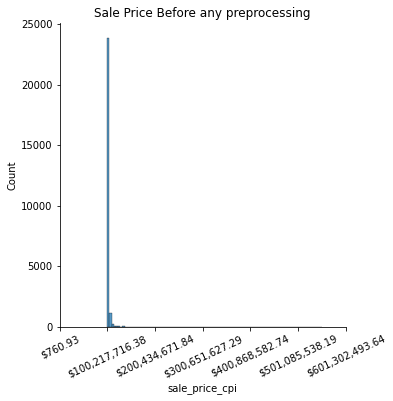

In [12]:
#This function will transform variables into US Currency
prop_func = lambda x: '${:,.2f}'.format(x)

#Plot the sale_price distribution
chart = sns.displot(merged_df['sale_price_cpi'], bins=100)
plt.title('Sale Price Before any preprocessing')
min_price = merged_df['sale_price_cpi'].min()
max_price = merged_df['sale_price_cpi'].max()
steps = (max_price-min_price)/9.0
labels = np.arange(min_price, max_price+1, steps)
labels = map(prop_func, labels)
chart.set(xticklabels=labels)
chart.set_xticklabels(rotation=25);

### Remove outliers and use log transformer on the target variable

In [13]:
#Define a function that calculates the boundaries for a feature
def find_skewed_boundaries(df, var, distance):
    
    IQR = df[var].quantile(.75) - df[var].quantile(.25)
    
    lower_boundary = df[var].quantile(.25) - (distance*IQR)
    upper_boundary = df[var].quantile(.75) + (distance*IQR)
    
    return upper_boundary, lower_boundary

The sale price upper boundary is 4512199.37
Number of observations before removing outliers: 25372
Number of observations after removing outliers: 21041
Removed 4331 observations


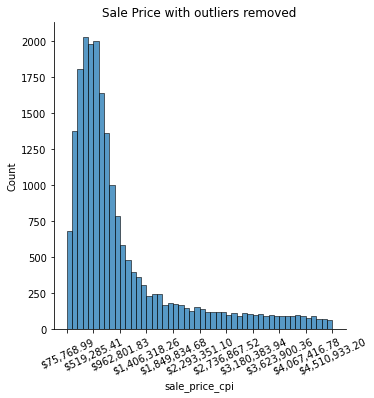

In [14]:
sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(merged_df, 'sale_price_cpi', 1.0)
print(f'The sale price upper boundary is {np.round(sales_upper_boundary,2)}')

#Remove outlier values
obs1 = merged_df.shape[0]
print(f'Number of observations before removing outliers: {obs1}')
merged_df = merged_df.loc[merged_df['sale_price_cpi']<sales_upper_boundary,:]
merged_df = merged_df.loc[merged_df['sale_price_cpi']>75000]
obs2 = merged_df.shape[0]
print(f'Number of observations after removing outliers: {obs2}')
print(f'Removed {obs1-obs2} observations')

#Plot for the sale_price distribution
chart = sns.displot(merged_df['sale_price_cpi'], bins=50)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
skip_step = (merged_df['sale_price_cpi'].max() - merged_df['sale_price_cpi'].min()) / 10
labels = np.round(np.arange(merged_df['sale_price_cpi'].min(), merged_df['sale_price_cpi'].max(), skip_step-1),2)
prop_labels = list(map(prop_func, labels))
chart.set(xticks=labels)
chart.set(xticklabels=prop_labels)
chart.set_xticklabels(rotation=25);

The sale price upper boundary is 1511.94
Number of observations before removing outliers: 21041
Number of observations after removing outliers: 18586
Removed 2455 observations


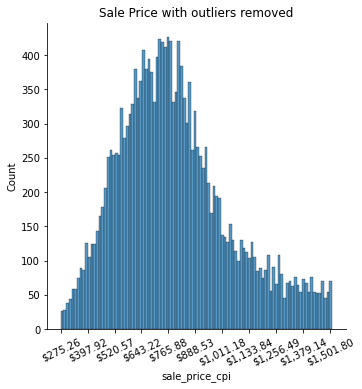

In [15]:
#Alternatively
#Power Transformer
et = vt.PowerTransformer(variables = ['sale_price_cpi', 'sale_price'])
et.fit(merged_df)

power_df = et.transform(merged_df)

sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(power_df, 'sale_price_cpi', 1.0)
print(f'The sale price upper boundary is {np.round(sales_upper_boundary,2)}')

#Remove outlier values
obs1 = power_df.shape[0]
print(f'Number of observations before removing outliers: {obs1}')
power_df = power_df.loc[power_df['sale_price_cpi']<sales_upper_boundary,:]
power_df = power_df.loc[power_df['sale_price_cpi']>sales_lower_boundary]
obs2 = power_df.shape[0]
print(f'Number of observations after removing outliers: {obs2}')
print(f'Removed {obs1-obs2} observations')

#Plot for the sale_price distribution
chart = sns.displot(power_df['sale_price_cpi'], bins=100)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
skip_step = (power_df['sale_price_cpi'].max() - power_df['sale_price_cpi'].min()) / 10
labels = np.round(np.arange(power_df['sale_price_cpi'].min(), power_df['sale_price_cpi'].max(), skip_step-1),2)
prop_labels = list(map(prop_func, labels))
chart.set(xticks=labels)
chart.set(xticklabels=prop_labels)
chart.set_xticklabels(rotation=25);

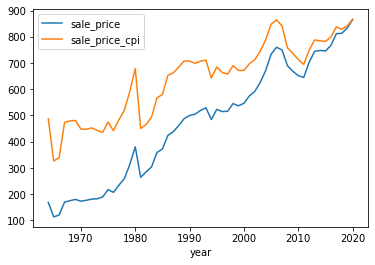

In [16]:
#Below you will see the change in price when adjusting for inflation
real_avg = power_df.groupby('year')['sale_price'].mean().plot()
adj_avg = power_df.groupby('year')['sale_price_cpi'].mean().plot()
plt.legend()
plt.show()

In [17]:
#Determine the age of the property 
power_df['age'] = power_df['date'].dt.year - power_df['year_built']
power_df[['year_built','age']].head()

,year_built,age
0,1979.00000,41.00000
1,1981.00000,39.00000
3,1926.00000,94.00000
4,1969.00000,51.00000
5,1972.00000,48.00000


In [18]:
#Examine the property type feature
temp = pd.concat([power_df.groupby('property_type')['sale_price_cpi'].mean(), power_df.groupby('property_type')['sale_price_cpi'].count(), power_df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price','Count', 'Frequency']
temp['Average sale price'] = temp['Average sale price']**2
temp.sort_values(by=['Count'], axis=0,ascending=False, inplace=True)
temp.dropna(inplace=True)
temp['Count'] = temp['Count'].astype(int)
temp['Average sale price'] = temp['Average sale price'].apply(lambda x: '${:,.2f}'.format(x))
temp['Frequency'] = temp['Frequency'].apply(lambda x: "{0:.2f}%".format(x*100))
print(f'Number of categories for property_type: {power_df.property_type.nunique()}')
temp

Number of categories for property_type: 24


,Average sale price,Count,Frequency
Single Family Residence,"$668,624.25",11742,63.18%
Condominium,"$537,564.16",4723,25.41%
"Duplex (2 units, any combination)","$619,762.76",708,3.81%
Planned Unit Development (PUD),"$627,379.38",617,3.32%
"Triplex (3 units, any combination)","$778,947.37",243,1.31%
"Quadplex (4 Units, Any Combination)","$752,949.12",227,1.22%
Apartment house (5+ units),"$1,034,283.44",223,1.20%
Residential - Vacant Land,"$839,653.49",24,0.13%
MISCELLANEOUS (Commercial),"$704,693.08",21,0.11%
Mobile home,"$275,891.58",17,0.09%


In [19]:
#Only keep the Single Family Residence 
print('Remove every property type except Single Family Residence')
num_1 = power_df.shape[0]
print(f'{num_1} total number of houses')
removed_df = power_df.loc[power_df['property_type']!='Single Family Residence']
num_2 = removed_df.shape[0]
print(f'{num_2} number of houses removed')
power_df = power_df.loc[power_df['property_type']=='Single Family Residence']
print(f'{power_df.shape[0]} number of Single Family Residence')

Remove every property type except Single Family Residence
18586 total number of houses
6844 number of houses removed
11742 number of Single Family Residence


Lot size upper boundary is 17024.25
Number of observations before removing outliers: 11742
Number of observations after removing outliers: 11003
Removed 739 observations


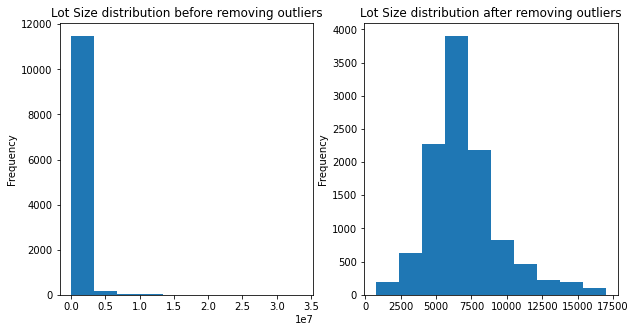

In [20]:
#Remove outliers for lot size
lot_size_upper_boundary, lot_size_lower_boundary = find_skewed_boundaries(power_df, 'lot_size', 3.0)
print(f'Lot size upper boundary is {lot_size_upper_boundary}')

#Remove outlier values
trimmed_df = power_df.loc[power_df['lot_size']<lot_size_upper_boundary,:]
print(f'Number of observations before removing outliers: {power_df.shape[0]}')
print(f'Number of observations after removing outliers: {trimmed_df.shape[0]}')
print(f'Removed {power_df.shape[0]-trimmed_df.shape[0]} observations')

fig, ax = plt.subplots(1,2, figsize=(10,5))

power_df['lot_size'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Lot Size distribution before removing outliers')

trimmed_df['lot_size'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Lot Size distribution after removing outliers')
plt.show()

In [21]:
#Cap the outliers for sex offenders and enviornmental hazards features
windsoriser = Winsorizer(distribution='skewed',
                          tail='right', 
                          fold=1.5,
                          variables=['sex_offenders','enviornmental_hazards'])

windsoriser.fit(trimmed_df)

trimmed_df = windsoriser.transform(trimmed_df)

In [22]:
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['crime_index', 'school_quality'])

ohe_encoder.fit(trimmed_df)

temp = ohe_encoder.transform(trimmed_df)

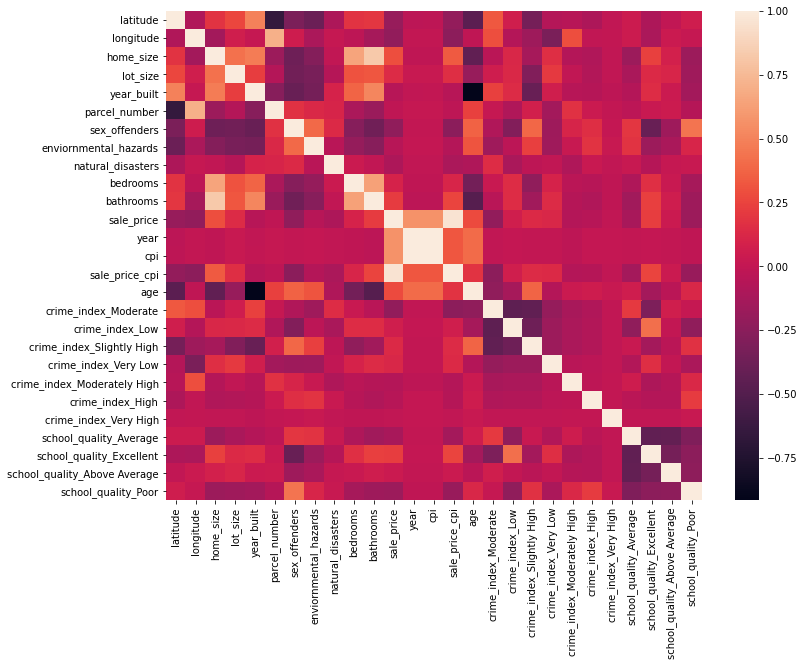

In [23]:
corrmat = temp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

In [24]:
def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(temp, 0.6)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  6
{'bathrooms', 'bedrooms', 'parcel_number', 'age', 'cpi', 'sale_price_cpi'}


In [25]:
#Let's examine crime index
temp = pd.concat([trimmed_df.groupby('crime_index')['sale_price'].mean(), trimmed_df.groupby('crime_index')['sale_price'].count()], axis=1)
temp.columns = ['Avg Sale Price \'Log Scale\'', 'Count of crime index type']
temp['Avg Sale Price \'Real Scale\''] = (temp['Avg Sale Price \'Log Scale\''])**2
temp.sort_values(by='Avg Sale Price \'Log Scale\'', ascending=False, inplace=True)
temp['Avg Sale Price \'Log Scale\''] = temp['Avg Sale Price \'Log Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp['Avg Sale Price \'Real Scale\''] = temp['Avg Sale Price \'Real Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp

,Avg Sale Price 'Log Scale',Count of crime index type,Avg Sale Price 'Real Scale'
crime_index,,,
Very Low,$863.85,792,"$746,230.93"
Slightly High,$809.91,2950,"$655,948.74"
Low,$780.44,3063,"$609,085.34"
Moderate,$668.67,3751,"$447,117.21"
Moderately High,$641.61,300,"$411,663.47"
High,$632.15,146,"$399,616.15"
Very High,$580.52,1,"$337,000.00"


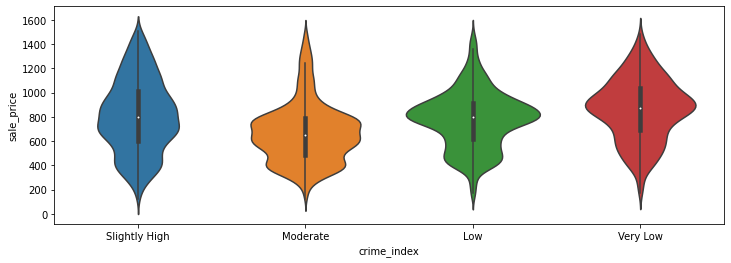

In [26]:
#Box Plot of Crime Index
order=['Slightly High', 'Moderate', 'Low', 'Very Low']
temp = trimmed_df.loc[((trimmed_df['crime_index']!='High') & (trimmed_df['crime_index']!='Moderately High'))]
plt.figure(figsize=(12,4))
sns.violinplot(x='crime_index', y='sale_price', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [27]:
#Let's examine school quality
temp = pd.concat([trimmed_df.groupby('school_quality')['sale_price'].mean(), trimmed_df.groupby('school_quality')['sale_price'].count()], axis=1)
temp.columns = ['Average Sale Price Log Scale', 'Count of school_quality types']
#temp['Average Sale Price Real Scale'] = temp['Average Sale Price Log Scale']
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Log Scale']**2
temp.sort_values(by='Average Sale Price Log Scale', ascending=False, inplace=True)
temp['Average Sale Price Log Scale'] = temp['Average Sale Price Log Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Real Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp

,Average Sale Price Log Scale,Count of school_quality types,Average Sale Price Real Scale
school_quality,,,
Excellent,$853.62,2856,"$728,665.67"
Above Average,$766.60,2754,"$587,672.65"
Average,$707.21,3848,"$500,140.61"
Poor,$638.79,1545,"$408,053.57"


In [33]:
#Create a dataset with just unique houses
drop_features = ['address','year_built', 'parcel_number', 'date', 'property_type', 'url', 'year', 'cpi', 'natural_disasters']
houses = trimmed_df.sort_values(by='date', ascending=False).reset_index(drop=True)
print(f'Number of observations before removing duplicate houses {houses.shape[0]}')
houses = houses.drop_duplicates(subset='address')
houses.drop(drop_features, axis=1, inplace=True)
houses.rename(columns={'sold_date': 'date'}, inplace=True)
houses['sale_price'] = houses['sale_price']**2
print(f'Number of observations after removing duplicate houses {houses.shape[0]}')
houses.to_csv('Data/houses.csv', index=False)

Number of observations before removing duplicate houses 11003
Number of observations after removing duplicate houses 6068


In [34]:
houses.head()

,latitude,longitude,home_size,lot_size,zoning,sex_offenders,crime_index,enviornmental_hazards,school_quality,bedrooms,bathrooms,sale_price,date,sale_price_cpi,age
0,34.01237,-118.40717,3247.00000,5011.00000,CCR1,1.00000,Moderate,6.00000,Excellent,4.00000,4.00000,1700000.00000,2020-12-01,1303.26887,41.00000
1,34.24249,-118.26143,986.00000,6180.00000,GLR1YY,5.00000,Low,2.00000,Excellent,2.00000,1.00000,767500.00000,2020-11-30,877.36761,72.00000
2,34.11711,-118.37095,3243.00000,8441.00000,LARE11,1.00000,Slightly High,2.00000,Excellent,3.00000,4.00000,700000.00000,2020-11-25,837.89853,20.00000
3,33.86358,-118.04897,1733.00000,5002.00000,CERS5000,5.00000,Low,7.00000,Excellent,4.00000,2.00000,845000.00000,2020-11-25,920.59956,48.00000
4,33.89263,-118.09006,728.00000,5088.00000,NOR1,22.00000,Moderate,5.00000,Above Average,2.00000,1.00000,535000.00000,2020-11-25,732.51968,70.00000


In [29]:
#Lets remove the features that won't be needed for the model
drop_features = ['address','year_built', 'parcel_number','date', 'sold_date', 'property_type', 'url', 'year', 'cpi', 'natural_disasters']
final_df = trimmed_df.drop(drop_features, axis=1)
final_df.to_csv('Data/house_data_details_eda.csv', index=False)